In this notebook I have put together a small dataset for mental health across the world. Four csv files were directly downloaded from the WHO data archive and then merged together after vigorous data manipulation and cleaning.<br>

Data is missing multiple countries as a large number of columns for those countries had missing values in the original data tables.

An exploratory data analysis (EDA) has also been done on the dataset.

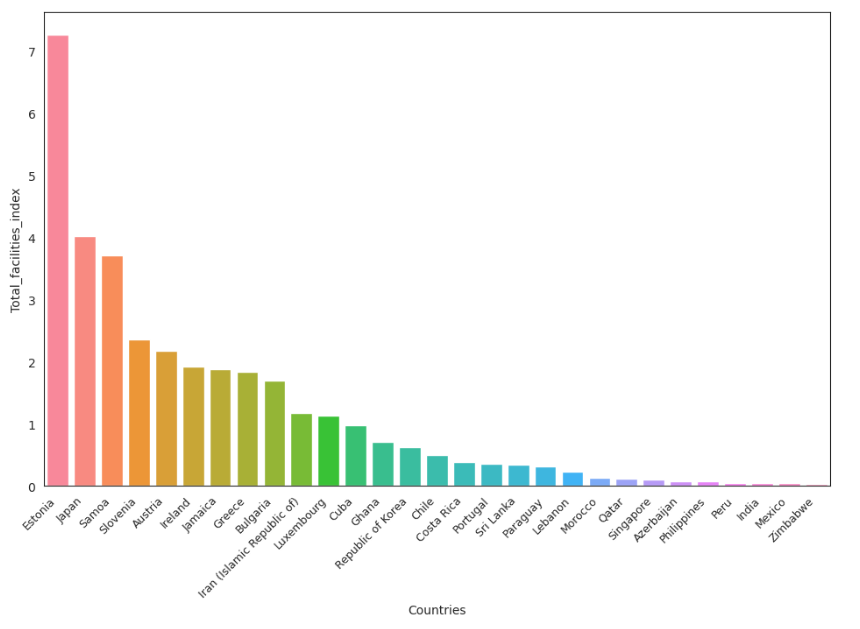

# import libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)

import seaborn as sns
sns.set_style('white')
sns.set_palette("tab10")

import matplotlib.pyplot as plt

import re
import os
import glob

# Load all csv files

In [ ]:
files = glob.glob( '/kaggle/input/mentalhealthdata/*.csv' )

dfs = {}
for file in files:
    df_name = file.split('/')[-1].split('.')[0]
    df = pd.read_csv( file )
    dfs[df_name] = df

# Preprocess Facilities dataset

In [ ]:
dfs['Facilities']

### rename columns

In [ ]:
cols = dfs['Facilities'].columns
print(f'Old columns: {cols}')

cols_shortened = []
for col in cols:
    # remove extra details
    col = re.split(r'(,)|( \()', col)[0]
    
    # remove "mental hospital" since repetetive
    if 'Mental ' in col:
        col = re.split(r'(Mental health )', col)[-1]
        
    # remove blank spaces
    col = col.replace(' ', '_')
    
    # attach
    cols_shortened.append( col )

print(f'New columns: {cols_shortened}')

dfs['Facilities'].columns = cols_shortened
dfs['Facilities'].head()

### check dtypes

In [ ]:
print( dfs['Facilities'].dtypes )

dfs['Facilities']['Countries'] = dfs['Facilities']['Countries'].astype('category')
dfs['Facilities']['Year'] = dfs['Facilities']['Year'].astype(np.uint16)

for col in dfs['Facilities'].select_dtypes(np.float64).columns:
    print( dfs['Facilities'][col].dtype )
    dfs['Facilities'][col] =  dfs['Facilities'][col].astype(np.float16)

print( dfs['Facilities'].dtypes )

### fill nans

In [ ]:
print( dfs['Facilities'].isna().sum() )

dfs['Facilities'].fillna(0)

# Preprocess Beds dataset

In [ ]:
df = dfs['Beds']
df.head(5)

### Pivot Year row to column

In [ ]:
df = dfs['Beds'].copy().fillna(0)
df = df.set_index('Unnamed: 0')

df = df.T
df = df.set_index(keys=['Countries, territories and areas'], append=True)
df = df.unstack()

df = df.T
df.reset_index(inplace=True)

cols = df.columns.tolist()
cols[0] = 'Countries'
cols[1] = 'Year'
df.columns = cols

df.head(5)

In [ ]:
def correct_vals(row, label):
    cols = row.index.tolist()
    selected_colss = [col for col in cols if re.search(label, col)]
    temp = row[selected_colss].dropna()
    if temp.size:
        temp = np.max( temp.values) 
        return temp
    else:
        return np.nan

df['Bed_general_hospitals'] = df.apply(lambda row: correct_vals(row, label='general hospitals'), axis=1)
df['Bed_residential_facilities'] = df.apply(lambda row: correct_vals(row, label='residential facilities'), axis=1)
df['Bed_mental_hospitals'] = df.apply(lambda row: correct_vals(row, label='mental hospitals'), axis=1)

df = pd.concat( [df.iloc[:, :2], df.iloc[:, -3:]], axis=1).fillna(0)
df

# correct dtypes

In [ ]:
print( df.dtypes )

df['Countries'] = df['Countries'].astype('category')
df['Year'] = df['Year'].astype(np.uint16).astype(np.uint16)

for col in df.columns.tolist()[2:]:
    df[col] = df[col].astype(np.float16)

print( df.dtypes )

dfs['Beds'] = df.copy()
dfs['Beds']

# Preprocess LifeExpectancy dataset

In [ ]:
df = dfs['LifeExpectency'].copy()
df.head(3)

### change column names

In [ ]:
cols = df.columns.tolist()
cols[0] = 'Countries'
cols[1] = 'Year'

suffix_dict = {'': '_MF', '.1': '_M', '.2': '_F'}

cols_corrected = []
for col in cols:
    if re.search('expectancy', col):
        key = re.split(r'\(years\)', col)[-1]
        suffix = suffix_dict[ key ]

        col = re.split(' \(years\)', col)[0]
        col = re.sub('\(HALE\) ', '', col)
        col = re.sub(' ', '_', col)
        col = col + suffix
    cols_corrected.append( col )

print(cols_corrected)

df.columns = cols_corrected

### Sort based on country and year

In [ ]:
df = df.drop(index=0, axis=0)
df = df.sort_values(by=['Countries', 'Year'])
df.reset_index(inplace=True, drop=True)
df

### check dtypes

In [ ]:
print( df.dtypes )

df['Countries'] = df['Countries'].astype('category')
df['Year'] = df['Year'].astype(np.uint16).astype(np.uint16)

for col in df.columns.tolist()[2:]:
    df[col] = df[col].astype(np.float16)

print( df.dtypes )

dfs['LifeExpectency'] = df.copy()
dfs['LifeExpectency']

# Preprocess Suicide dataset

In [ ]:
df = dfs['Suicide'].copy()
df.head(3)

In [ ]:
df = df.set_axis(labels= df.iloc[0,:].values.tolist(), axis=1)
df = df.iloc[1:, :].copy().reset_index(drop=True)
df.head(4)

### Pivot Sex row to column


In [ ]:
df = df.set_index(keys=['Countries, territories and areas', 'Sex'])
df = df.unstack()
df = df.swaplevel(axis=1)
df = df.stack()
df

# remove range from values

In [ ]:
df = df.applymap(lambda val: val.split(' ')[0])
df = df.astype(np.float16)
df

### bring back countries and years to columns

In [ ]:
df.reset_index(inplace=True)
df.head(3)

### rename labels

In [ ]:
df.index.names = ['']
df.columns.names = ['']
df

### correct columns names

In [ ]:
cols = df.columns.tolist()
print(f'Old columns: {cols}')

cols[0] = 'Countries'
cols[1] = 'Year'

for ind, col in enumerate(cols):
    if ind >= 2:
        col = 'Suicide_rate' + col.lower()
        cols[ind] = re.sub(' ', '_', col)

df.columns = cols
print(f'New columns: {cols}')

### check dtypes

In [ ]:
print( df.dtypes)

df['Countries'] = df['Countries'].astype('category')
df['Year'] = df['Year'].astype(np.int16).astype(np.uint16)

print(df.dtypes)

In [ ]:
dfs['Suicide'] = df.copy().sort_values(by=['Countries', 'Year'])
dfs['Suicide']

# Merge datasets

In [ ]:
df_total = pd.merge(dfs['Facilities'], dfs['Beds'], how='outer', on=['Countries', 'Year'])
df_total = pd.merge(df_total, dfs['LifeExpectency'], how='outer', on=['Countries', 'Year'])
df_total = pd.merge(df_total, dfs['Suicide'], how='outer', on=['Countries', 'Year'])
df_total

# Average over years since data is nonoverlapping for most of years

In [ ]:
df_total = df_total.groupby(['Countries']).mean()
df_total.drop('Year', axis=1, inplace=True)
df_total = df_total.dropna(how='any')
df_total.reset_index(inplace=True)
df_total.head(5)

# Extract correlation between variables within each category

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.ravel()

for ind, key in enumerate( dfs.keys() ):
    cols = dfs[key].columns.tolist()[2:]
    g = sns.heatmap( df_total[cols].corr(), ax=ax[ind], annot=True, center=0, vmin=-1, vmax=1)
    g.set_xticklabels(g.get_xticklabels(), rotation = 90, fontsize = 8)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
    ax[ind].set_aspect(1)
    ax[ind].set_title(key)
    
fig.tight_layout(w_pad=0.7, h_pad=0.7)

# Extract total metrics

In [ ]:
df_total['Total_facilities_index'] = df_total.iloc[:, 1:6].mean(axis=1)
df_total['Total_beds_index'] = df_total.iloc[:, 6:9].mean(axis=1)

cols = [col for col in df_total.columns if ('expectancy' in col) and ('60' not in col)]
df_total['Total_life_expectancy_index'] = df_total.loc[:, cols].mean(axis=1)

cols = [col for col in df_total.columns if ('Suicide' in col)]
df_total['Total_suicide_index'] = df_total.loc[:, cols].mean(axis=1)

df_total

# extract correlation of total metrics

In [ ]:
sns.heatmap( df_total.iloc[:, -4:].corr(), annot=True, cmap='seismic', center=0)
_ = plt.title('Correlation of metrics across countries')

**In seems like the suicide rate is negatively correlated with life expectancy. Also interestingly, total number of mental facilities and beds are positively correlated. This correlation is probably causal in the sense that a country with higher suicide rate would have to invest more in infrastructure of mental health**

# Bar chart of metrics across countries

In [ ]:
fig, ax= plt.subplots(2,2,figsize=(20,15))
ax = ax.ravel()

for ind, col in enumerate( df_total.columns.tolist()[-4:] ):
    g = sns.barplot(data=df_total, x=df_total.sort_values(col, ascending=False)['Countries'], y=col, ax=ax[ind], saturation=1)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, fontsize=9, ha="right")
    _ = plt.title('Number of Mental health hospitals per country')

fig.tight_layout(w_pad=5, h_pad=5)

**Zimbabwe has the highest rate of suicide and lowest life expectancy. Whereas it has the least numebr of mental facilities**

# pairplot of all metrics

In [ ]:
_ = sns.pairplot(df_total.iloc[:, -4:], kind='reg', diag_kind='kde')

# save dataset

In [ ]:
df_total.to_csv('Mental_health_WHO_per_country.csv', index=False)